In [88]:
"""
Different flavors of visual population receptive field models
==============================================================

In this example script we will try out increasingly complex models for
visual population receptive fields (PRFs). We will start with a simple
Gaussian PRF model, and then add more complexity step by step.

"""

# %%
# First we load in the data. We will use the Szinte (2024)-dataset.
from braincoder.utils.data import load_szinte2024

data = load_szinte2024()

# This is the visual stimulus ("design matrix")
paradigm = data['stimulus']
grid_coordinates = data['grid_coordinates']

# This is the fMRI response data
d = data['v1_timeseries']
tr = data['tr']


# %%
# Now we set up a simple Gaussian PRF model
from braincoder.models import GaussianPRF2DWithHRF
from braincoder.hrf import SPMHRFModel
hrf_model = SPMHRFModel(tr=tr)
model = GaussianPRF2DWithHRF(data=d, paradigm=paradigm, hrf_model=hrf_model, grid_coordinates=grid_coordinates)

# %%
# And a parameter fitter...
from braincoder.optimize import ParameterFitter
par_fitter = ParameterFitter(model=model, data=d, paradigm=paradigm)


# %%
# Now we try out a relatively coarse grid search to find the some
# parameters to start the gradient descent from.
import numpy as np
x = np.linspace(-8, 8, 20)
y = np.linspace(-4, 4, 20)
sd = np.linspace(0.5, 4, 20)

# We start the grid search using a correlation cost, so ampltiude
# and baseline do not influence those results.
# We will optimize them later using OLS.
baseline = [0.0]
amplitude = [1.0]

# Let's double-check the order of the parameters
print(model.parameter_labels)

# Now we can do the grid search
pars_grid_search = par_fitter.fit_grid(x, y, sd, baseline, amplitude, correlation_cost=True)

pars_grid_search_ols = par_fitter.refine_baseline_and_amplitude(pars_grid_search)

# %%
# Let's optimize further using gradient descent
pars = par_fitter.fit(init_pars=pars_grid_search_ols, max_n_iterations=1000)



['x', 'y', 'sd', 'baseline', 'amplitude']
Working with chunk size of 1879


  0%|          | 0/5 [00:00<?, ?it/s]

/Users/gdehol/git/braincoder/braincoder/optimize.py:406: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.37946439 0.26413465 0.45994616 ... 0.07501367 0.05776712 0.08403344]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  parameters.loc[ix] = new_parameters.loc[ix]


Number of problematic voxels (mask): 57
Number of voxels remaining (mask): 2308


  0%|          | 0/1000 [00:00<?, ?it/s]

In [89]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Get the R2 for the gradient descent parameters
r2_gd = par_fitter.get_rsq(pars)

In [90]:
r2_gd.shape

(2365,)

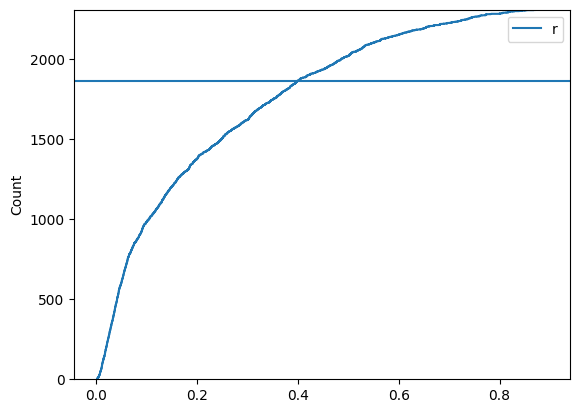

In [91]:
sns.ecdfplot(data=r2_gd.to_frame('r'), stat='count')

plt.axhline(r2_gd.shape[0] - 500)


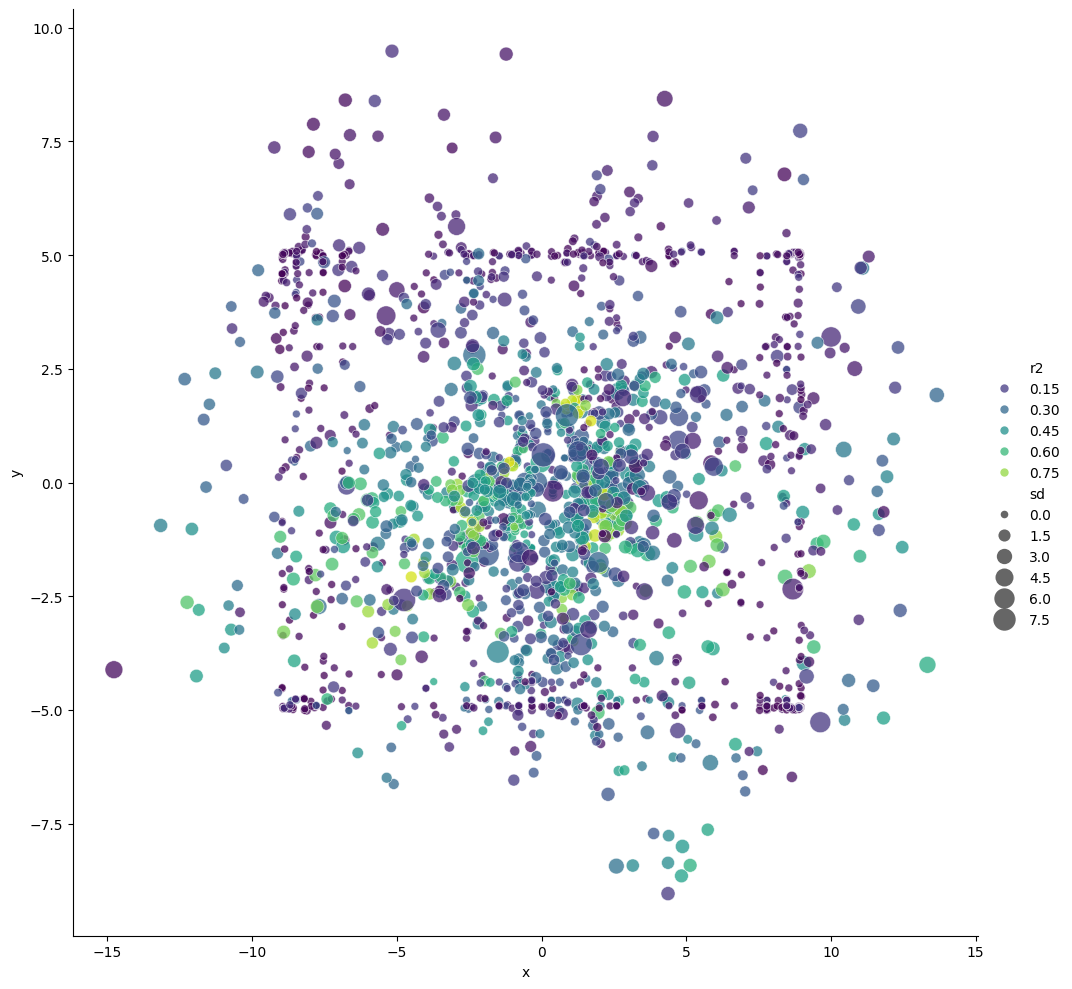

In [92]:
# %%
# Of course we can also plot some of the most important
# parameters to see if they make sense
sns.relplot(x='x', y='y', data=pars.join(r2_gd.to_frame('r2')), hue='r2', size='sd', sizes=(30, 300), alpha=0.75, palette='viridis', height=10)

In [93]:
# %%
# One extension of the model is to make sure that the HRFs are
# estimated independently for each voxel. This is done by
# setting up a new model where flexible_hrf_parameters is 
# set to True

model_hrf = GaussianPRF2DWithHRF(data=d, paradigm=paradigm, hrf_model=hrf_model, grid_coordinates=grid_coordinates, flexible_hrf_parameters=True)


# now optimize
par_fitter_hrf = ParameterFitter(model=model_hrf, data=d, paradigm=paradigm)
pars_hrf = pars.copy()

# let's start with default values
pars_hrf['hrf_delay'] = 6.0
pars_hrf['hrf_dispersion'] = 1.0

# and optimize...
pars_hrf = par_fitter_hrf.fit(init_pars=pars_hrf, max_n_iterations=1000)

Number of problematic voxels (mask): 57
Number of voxels remaining (mask): 2308


  0%|          | 0/1000 [00:00<?, ?it/s]

(1, 150, 2365) (24, 2365)


<Axes: xlabel='Count', ylabel='r2'>

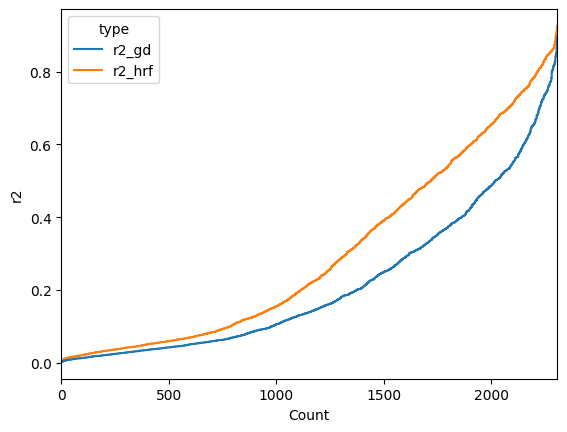

In [94]:
# %%
# The R2s got much higher!
r2_hrf = par_fitter_hrf.get_rsq(pars_hrf)

# Combine them
r2 = pd.concat((r2_gd, r2_hrf), keys=['r2_gd', 'r2_hrf'], names=['type'], axis=1)

sns.ecdfplot(data=r2.stack().to_frame('r2'), stat='count', y='r2', hue='type')

<Axes: xlabel='sd', ylabel='Count'>

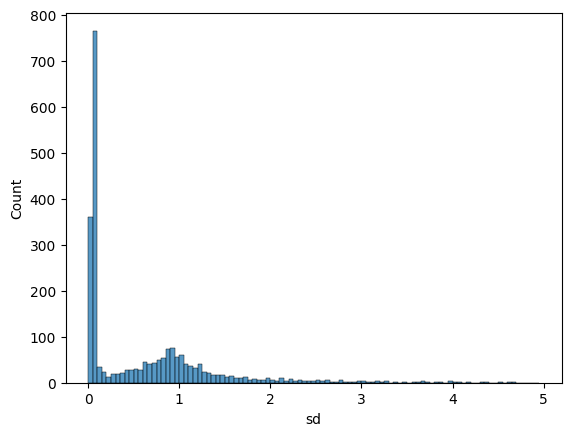

In [95]:
sns.histplot(pars_hrf['sd'], bins=np.arange(0, 5, .05))

In [96]:
r2_hrf[pars_hrf['sd'] > 0.5]

source
0       0.752930
1       0.599096
2       0.833681
3       0.686688
4       0.732967
          ...   
2352    0.190374
2354    0.185340
2356    0.107833
2358    0.442778
2364    0.135748
Name: r2, Length: 1052, dtype: float32

In [97]:
best_voxels_hrf

Index(['1065', '1058', '2167', '1059', '1066', '2168', '115', '2065', '1980',
       '1947',
       ...
       '2203', '160', '1948', '1876', '811', '574', '429', '589', '1691',
       '400'],
      dtype='object', name='source', length=200)

In [98]:
from braincoder.optimize import ResidualFitter, StimulusFitter

best_voxels_hrf = r2_hrf[pars_hrf['sd'] > 0.5].sort_values(ascending=False).index[:200]
model = GaussianPRF2DWithHRF(data=d.loc[:, best_voxels_hrf], paradigm=paradigm, hrf_model=hrf_model, grid_coordinates=grid_coordinates, flexible_hrf_parameters=False)
resid_fitter_gauss = ResidualFitter(model, d.loc[:, best_voxels_hrf], parameters=pars_hrf.loc[best_voxels_hrf])
omega_gauss, dof_gauss = resid_fitter_gauss.fit()



init_tau: 0.2439173012971878, 0.6616331934928894
USING A PSEUDO-WWT!
WWT max: 0.006621453911066055


  0%|          | 0/1000 [00:00<?, ?it/s]

In [99]:
from braincoder.optimize import StimulusFitter

In [100]:
data = load_szinte2024(resize_factor=2.5)

d = data['v1_timeseries']
grid_coordinates = data['grid_coordinates']


model = GaussianPRF2DWithHRF(data=d.loc[:, best_voxels_hrf], hrf_model=hrf_model, grid_coordinates=grid_coordinates, flexible_hrf_parameters=False)

In [101]:
stim_fitter = StimulusFitter(model=model, data=d.loc[:, best_voxels_hrf], parameters=pars_hrf.loc[best_voxels_hrf], omega=omega_gauss)

reconstructed_stimulus500 = stim_fitter.fit(max_n_iterations=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

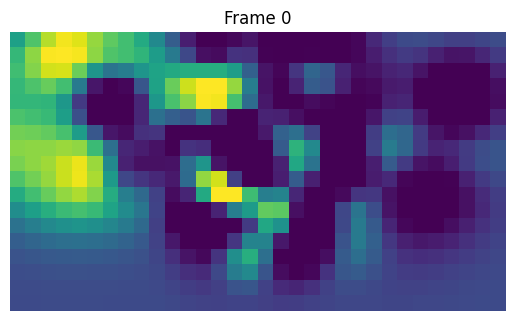

In [102]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

def play_reconstruction(reconstructed_stimulus):

  # Here we make a movie of the decoded stimulus
  # Set up a function to draw a single frame
  vmin, vmax = np.quantile(reconstructed_stimulus.values.ravel(), 0.01), np.quantile(reconstructed_stimulus.values.ravel(), 0.99)

  def update(frame):
      plt.clf()  # Clear the current figure
      plt.imshow(reconstructed_stimulus.stack('y').loc[frame], cmap='viridis', vmin=vmin, vmax=vmax)
      plt.axis('off')
      plt.title(f"Frame {frame}")

  # Create the animation
  fig = plt.figure()
  ani = FuncAnimation(fig, update, frames=range(reconstructed_stimulus.shape[0]), interval=100)

  return HTML(ani.to_html5_video())

play_reconstruction(reconstructed_stimulus500)

<Axes: xlabel='sd', ylabel='Count'>

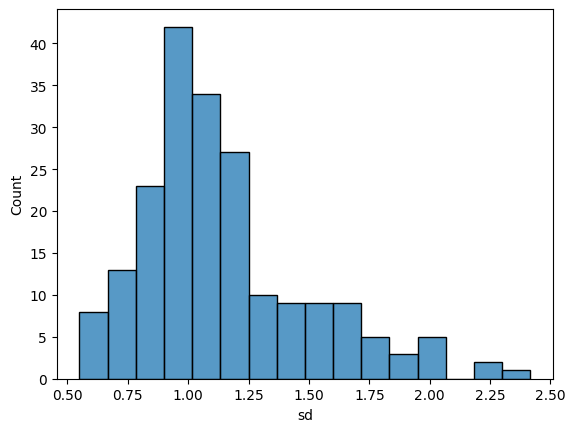

In [103]:
sns.histplot(pars_hrf.loc[best_voxels_hrf]['sd'])

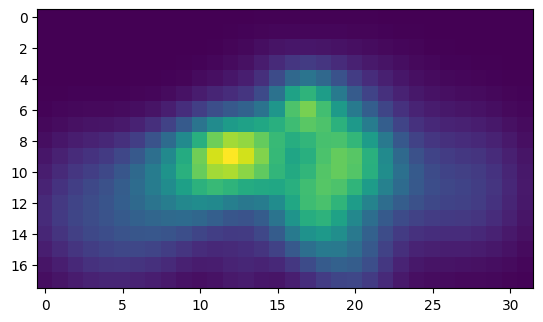

In [104]:
plt.imshow(model.get_rf(unpack=True).sum(0).reshape(data['stimulus'][0].shape).T)

In [106]:
# Do the same for the DoG-model
model_dog_hrf = DifferenceOfGaussiansPRF2DWithHRF(data=data['v1_timeseries'].loc[:, best_voxels_dog],
                                   paradigm=data['stimulus'],
                                   hrf_model=hrf_model,
                                   parameters=pars_dog_hrf.loc[best_voxels_dog],
                                   grid_coordinates=data['grid_coordinates'],
                                   flexible_hrf_parameters=False)
stim_fitter_dog = StimulusFitter(data['v1_timeseries'].loc[:, best_voxels_dog], model_dog_hrf, omega_dog)
reconstructed_stimulus_dog_hrf = stim_fitter_dog.fit(l2_norm=0.01, learning_rate=.1)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

(1, 200, 7) (1, 200, 5)


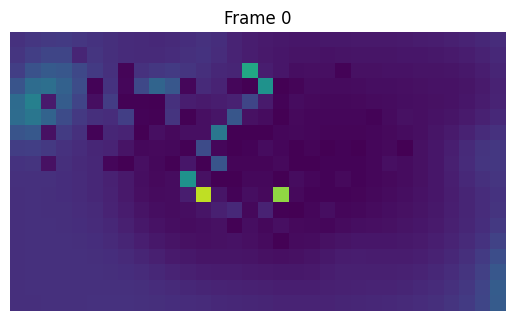

In [107]:
play_reconstruction(reconstructed_stimulus_dog_hrf)

In [301]:
class DivisiveNormalizationGaussianPRF2D(GaussianPRF2D):
    # Amplitude is as a fraction of the positive amplitude and is limited to be within [0, 1]
    # srf factor is limited to be above 1
    parameter_labels = ['x', 'y', 'sd', 'baseline', 'amplitude', 'srf_amplitude', 'srf_factor', 'neural_baseline', 'surround_baseline']

    @tf.function
    def _transform_parameters_forward(self, parameters):
        return tf.concat([parameters[:, 0][:, tf.newaxis],
                          parameters[:, 1][:, tf.newaxis],
                          tf.math.softplus(parameters[:, 2][:, tf.newaxis]),
                          parameters[:, 3][:, tf.newaxis],
                          parameters[:, 4][:, tf.newaxis],
                          tf.math.softplus(parameters[:, 5][:, tf.newaxis]),
                          tf.math.softplus(parameters[:, 6][:, tf.newaxis]) + 1,
                          tf.math.softplus(parameters[:, 7][:,tf.newaxis]),
                          tf.math.softplus(parameters[:, 8][:,tf.newaxis]),
                          ], axis=1)

    @tf.function
    def _transform_parameters_backward(self, parameters):
        return tf.concat([parameters[:, 0][:, tf.newaxis],
                          parameters[:, 1][:, tf.newaxis],
                          tfp.math.softplus_inverse(
                              parameters[:, 2][:, tf.newaxis]),
                          parameters[:, 3][:, tf.newaxis],
                          parameters[:, 4][:, tf.newaxis],
                          tfp.math.softplus_inverse(
                              parameters[:, 5][:, tf.newaxis]),
                          tfp.math.softplus_inverse(parameters[:, 6][:, tf.newaxis] - 1),
                          tfp.math.softplus_inverse(parameters[:, 7][:, tf.newaxis]),
                          tfp.math.softplus_inverse(parameters[:, 8][:, tf.newaxis])], axis=1)


    @tf.function
    def _basis_predictions(self, paradigm, parameters):
        # paradigm: n_batches x n_timepoints x n_stimulus_features
        # parameters:: n_batches x n_voxels x n_parameters

        # norm: n_batches x n_timepoints x n_voxels

        # output: n_batches x n_timepoints x n_voxels


        mu_x = parameters[:, :, 0, tf.newaxis]
        mu_y = parameters[:, :, 1, tf.newaxis]
        sd = parameters[:, :, 2, tf.newaxis]
        baseline = parameters[tf.newaxis, :, :, 3]
        amplitude = parameters[:, :, 4, tf.newaxis]
        rf_parameters = tf.concat([mu_x, mu_y, sd, tf.zeros_like(mu_x), amplitude], axis=2)
        rf = self._get_rf(self.grid_coordinates, rf_parameters)

        srf_amplitude = parameters[:, :, 5, tf.newaxis]
        srf_size = parameters[:, :, 6, tf.newaxis]

        srf_parameters = tf.concat([mu_x, mu_y, sd*srf_size, tf.zeros_like(mu_x), srf_amplitude*amplitude*srf_size], axis=2)

        srf = self._get_rf(self.grid_coordinates, srf_parameters)

        neural_baseline = parameters[tf.newaxis, :, :, 7]
        surround_baseline = parameters[tf.newaxis, :, :, 8]

        # [1,150,2365], [1,2365,1]
        neural_activation = tf.tensordot(paradigm, rf, (2, 2))[:, :, 0, :] + neural_baseline
        normalization = tf.tensordot(paradigm, srf, (2, 2))[:, :, 0, :] + surround_baseline

        normalized_activation = (neural_activation / normalization) - (surround_baseline / neural_baseline)

        if isinstance(self, DivisiveNormalizationGaussianPRF2D):
            normalized_activation += baseline

        return normalized_activation

class DivisiveNormalizationGaussianPRF2DWithHRF(HRFEncodingModel, DivisiveNormalizationGaussianPRF2D):

    def __init__(self, grid_coordinates=None, paradigm=None, data=None, parameters=None,
                 positive_image_values_only=True,
                 weights=None, hrf_model=None, flexible_hrf_parameters=False, verbosity=logging.INFO, **kwargs):

        DivisiveNormalizationGaussianPRF2D.__init__(self, grid_coordinates=grid_coordinates, paradigm=paradigm, data=data, parameters=parameters, weights=weights, verbosity=verbosity,
                        positive_image_values_only=positive_image_values_only, **kwargs)

        HRFEncodingModel.__init__(self, hrf_model=hrf_model, flexible_hrf_parameters=flexible_hrf_parameters, **kwargs)

    @tf.function
    def _transform_parameters_forward(self, parameters):

        if self.flexible_hrf_parameters:
            n_hrf_pars = len(self.hrf_model.parameter_labels)

            encoding_pars = DivisiveNormalizationGaussianPRF2D._transform_parameters_forward(self, parameters[:, :-n_hrf_pars])
            hrf_pars = self.hrf_model._transform_parameters_forward(parameters[:, -n_hrf_pars:])
            
            return tf.concat([encoding_pars, hrf_pars], axis=1)
        else:
            return DivisiveNormalizationGaussianPRF2D._transform_parameters_forward(self, parameters)

    @tf.function
    def _transform_parameters_backward(self, parameters):
        
        if self.flexible_hrf_parameters:
            n_hrf_pars = len(self.hrf_model.parameter_labels)

            encoding_pars = DivisiveNormalizationGaussianPRF2D._transform_parameters_backward(self, parameters[:, :-n_hrf_pars])
            hrf_pars = self.hrf_model._transform_parameters_backward(parameters[:, -n_hrf_pars:])
            
            return tf.concat([encoding_pars, hrf_pars], axis=1)
        else:
            return DivisiveNormalizationGaussianPRF2D._transform_parameters_backward(self, parameters)


    def _predict(self, paradigm, parameters, weights):
        baseline = parameters[tf.newaxis, :, :, 3]
        return HRFEncodingModel._predict(self, paradigm, parameters, weights) + baseline

In [291]:
class ParameterFitter(object):

    def __init__(self, model, data, paradigm, memory_limit=666666666, log_dir=False):
        self.model = model
        self.data = data.astype(np.float32)
        self.paradigm = model.get_paradigm(paradigm)

        self.memory_limit = memory_limit  # 8 GB?

        self.log_dir = log_dir

        if log_dir is None:
            log_dir = op.abspath('logs/fit')

        if log_dir is not False:
            if not op.exists(log_dir):
                os.makedirs(log_dir)
            self.summary_writer = tf.summary.create_file_writer(op.join(log_dir,
                                                                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S")))

    def fit(self, max_n_iterations=1000,
            min_n_iterations=100,
            init_pars=None,
            confounds=None,
            optimizer=None,
            fixed_pars=None,
            store_intermediate_parameters=False,
            r2_atol=0.000001,
            lag=100,
            learning_rate=0.01,
            progressbar=True,
            legacy_adam=False,
            **kwargs):

        n_voxels, n_pars = self.data.shape[1], len(self.model.parameter_labels)

        y = self.data.values

        if optimizer is None:

            if legacy_adam:
                opt = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate, **kwargs)
            else:
                opt = tf.optimizers.Adam(learning_rate=learning_rate, **kwargs)

        if init_pars is None:
            init_pars = self.model.get_init_pars(
                data=y, paradigm=self.paradigm, confounds=confounds)
            print('using get_init_pars')

        init_pars = self.model._get_parameters(init_pars)
        init_pars = self.model._transform_parameters_backward(init_pars.values.astype(np.float32))

        ssq_data = tf.reduce_sum(
            (y - tf.reduce_mean(y, 0)[tf.newaxis, :])**2, 0)

        # Voxels with no variance to explain can confuse the optimizer to a large degree,
        # since the gradient landscape is completely flat.
        # Therefore, we only optimize voxels where there is variance to explain
        meaningful_ts = ssq_data > 0.0

        if fixed_pars is None:
            parameter_ix = range(n_pars)
        else:
            parameter_ix = [ix for ix, label in enumerate(self.model.parameter_labels) if label not in fixed_pars]

            print('*** Only fitting: ***')
            for ix in parameter_ix:
                print(f' * {self.model.parameter_labels[ix]}')

        parameter_ix = tf.constant(parameter_ix, dtype=tf.int32)

        n_meaningful_ts = tf.reduce_sum(tf.cast(meaningful_ts, tf.int32))
        n_trainable_pars = len(parameter_ix)

        update_feature_ix, update_parameter_ix = tf.meshgrid(tf.cast(tf.where(meaningful_ts), tf.int32), parameter_ix)
        update_ix = tf.stack((tf.reshape(update_feature_ix, tf.size(update_feature_ix)),
                              tf.reshape(update_parameter_ix, tf.size(update_parameter_ix))), 1)

        print(
            f'Number of problematic voxels (mask): {tf.reduce_sum(tf.cast(meaningful_ts == False, tf.int32))}')
        print(
            f'Number of voxels remaining (mask): {tf.reduce_sum(tf.cast(meaningful_ts == True, tf.int32))}')

        trainable_parameters = tf.Variable(initial_value=tf.gather_nd(init_pars, update_ix),
                                           shape=(n_meaningful_ts*n_trainable_pars),
                                           name='estimated_parameters', dtype=tf.float32)

        trainable_variables = [trainable_parameters]

        if confounds is not None:
            # n_voxels x 1 x n_timepoints x n variables
            confounds = tf.repeat(
                confounds[tf.newaxis, tf.newaxis, :, :], n_voxels, 0)

        if store_intermediate_parameters:
            intermediate_parameters = []

        mean_best_r2s = []

        paradigm_ = self.model.stimulus._clean_paradigm(self.paradigm)

        if confounds is None:
            @tf.function
            def get_ssq(parameters):
                predictions = self.model._predict(
                    paradigm_[tf.newaxis, ...], parameters[tf.newaxis, ...], None)

                residuals = y - predictions[0]

                ssq = tf.reduce_sum(residuals**2, 0)
                return ssq

        else:
            @tf.function
            def get_ssq(parameters):
                predictions_ = self.model._predict(
                    paradigm_[tf.newaxis, ...], parameters[tf.newaxis, ...], None)

                predictions = tf.transpose(predictions_)[
                    :, tf.newaxis, :, tf.newaxis]
                X = tf.concat([predictions, confounds], -1)
                beta = tf.linalg.lstsq(X, tf.transpose(
                    y)[:, tf.newaxis, :, tf.newaxis])
                predictions = tf.transpose((X @ beta)[:, 0, :, 0])

                residuals = y - predictions[0]

                ssq = tf.squeeze(tf.reduce_sum(residuals**2))
                ssq = tf.clip_by_value(
                    tf.math.reduce_variance(residuals, 0), 1e-6, 1e12)
                return ssq

        if optimizer is None:
            pbar = range(max_n_iterations)
            if progressbar:
                pbar = tqdm(pbar)

            best_r2 = tf.ones(y.shape[1]) * -1e3
            best_parameters = tf.zeros(init_pars.shape)

            for step in pbar:
                with tf.GradientTape() as t:
                    parameters = tf.tensor_scatter_nd_update(
                        init_pars, update_ix, trainable_parameters)
                    untransformed_parameters = self.model._transform_parameters_forward(
                        parameters)

                    ssq = get_ssq(untransformed_parameters)
                    cost = tf.reduce_sum(ssq)

                gradients = t.gradient(cost, trainable_variables)
                r2 = (1 - (ssq / ssq_data))

                improved_r2s = r2 > best_r2
                best_parameters = tf.where(
                    improved_r2s[:, tf.newaxis], untransformed_parameters, best_parameters)
                best_r2 = tf.where(improved_r2s, r2, best_r2)

                mean_current_r2 = r2[meaningful_ts].numpy().mean()
                mean_best_r2 = best_r2[meaningful_ts].numpy().mean()

                if step >= min_n_iterations:
                    r2_diff = mean_best_r2 - \
                        mean_best_r2s[np.max((step - lag, 0))]
                    if (r2_diff >= 0.0) & (r2_diff < r2_atol):
                        if progressbar:
                            pbar.close()
                        break

                mean_best_r2s.append(mean_best_r2)

                if hasattr(self, 'summary_write'):
                    with self.summary_writer.as_default():
                        tf.summary.scalar('mean R2', mean_r2, step=step)

                if store_intermediate_parameters:
                    p = untransformed_parameters.numpy().T
                    intermediate_parameters.append(
                        np.reshape(p, np.prod(p.shape)))
                    intermediate_parameters[-1] = np.concatenate(
                        (intermediate_parameters[-1], r2), 0)

                opt.apply_gradients(zip(gradients, trainable_variables))

                if progressbar:
                    pbar.set_description(
                        f'Current R2: {mean_current_r2:0.5f}/Best R2: {mean_best_r2:0.5f}')

            if store_intermediate_parameters:
                columns = pd.MultiIndex.from_product([self.model.parameter_labels + ['r2'],
                                                      np.arange(n_voxels)],
                                                     names=['parameter', 'voxel'])

                self.intermediate_parameters = pd.DataFrame(intermediate_parameters,
                                                            columns=columns,
                                                            index=pd.Index(np.arange(len(intermediate_parameters)),
                                                                           name='step'))

            self.estimated_parameters = format_parameters(
                best_parameters.numpy(), self.model.parameter_labels)

        elif optimizer.endswith('bfgs'):

            def bfgs_cost(trans_parameters):
                parameters = self.model._transform_parameters_forward(
                    trans_parameters)
                return tfp.math.value_and_gradient(get_ssq, parameters)

            if optimizer == 'bfgs':
                optim_results = tfp.optimizer.bfgs_minimize(bfgs_cost,
                                                            initial_position=init_pars, tolerance=1e-6,
                                                            max_iterations=500)
            elif optimizer == 'lbfgs':
                optim_results = tfp.optimizer.lbfgs_minimize(bfgs_cost,
                                                             initial_position=init_pars, tolerance=1e-6,
                                                             max_iterations=500)

            self.estimated_parameters = format_parameters(
                optim_results.position, self.model.parameter_labels)

            ssq = get_ssq(optim_results.position)

        self.estimated_parameters.index = self.data.columns

        if not self.estimated_parameters.index.name:
            self.estimated_parameters.index.name = 'source'

        self.predictions = self.model.predict(
            self.paradigm, self.estimated_parameters, self.model.weights)
        self.r2 = pd.Series(best_r2.numpy(), index=self.data.columns)

        return self.estimated_parameters

    def fit_grid(self, *args, fixed_pars=None,
            use_correlation_cost=False, **kwargs):

        # Calculate a proper chunk size for cutting up the parameter grid
        n_timepoints, n_voxels = self.data.shape
        chunk_size = self.memory_limit / n_voxels / n_timepoints
        chunk_size = int(kwargs.pop('chunk_size', chunk_size))
        print(f'Working with chunk size of {chunk_size}')

        if fixed_pars is not None:
            raise NotImplementedError()

        # Make sure that ranges for all parameters are given ing
        # *args or **kwargs
        if len(args) == len(self.model.parameter_labels):
            kwargs = dict(zip(self.model.parameter_labels, args))

        if not list(kwargs.keys()) == self.model.parameter_labels:
            raise ValueError(
                f'Please provide parameter ranges for all these parameters: {self.model.parameter_labels}')

        def _create_grid(model, *args):
            parameters = pd.MultiIndex.from_product(
                args, names=model.parameter_labels).to_frame(index=False)
            return parameters

        grid_args = [kwargs[key] for key in self.model.parameter_labels]

        # n_permutations x n_pars
        par_grid = _create_grid(self.model, *grid_args).astype(np.float32)

        # # Add chunks to the parameter columns, to process them chunk-wise and save memory
        par_grid = par_grid.set_index(
            pd.Index(par_grid.index // chunk_size, name='chunk'), append=True)

        n_chunks = ((len(par_grid) - 1) // chunk_size) + 1
        n_pars = par_grid.shape[1]
        n_features = self.data.shape[1]

        logging.info('Built grid of {len(par_grid)} parameter settings...')

        data = self.data.values

        paradigm_ = self.model.stimulus._clean_paradigm(self.paradigm)

        if use_correlation_cost:

            print("Using correlation cost!")

            data_demeaned = data - tf.reduce_mean(data, 0, True)
            ssq_data = tf.reduce_sum(data_demeaned**2, 0,True)

            @tf.function
            def _cost(par_grid):
                grid_predictions = self.model._predict(paradigm_[tf.newaxis, ...],
                                                       par_grid[tf.newaxis, ...], None)

                grid_predictions_demeaned = grid_predictions[0] -  tf.reduce_mean(grid_predictions[0], 0, True)
                ssq_predictions = tf.reduce_sum(grid_predictions_demeaned**2, 0,True)

                r = tf.reduce_sum(grid_predictions_demeaned[:, tf.newaxis, :]*data_demeaned[:, :, tf.newaxis], 0,True) / tf.math.sqrt(ssq_predictions[:, tf.newaxis,:]*ssq_data[:, :, tf.newaxis])
                r = r[0]
                best_ixs = tf.argmax(r, 1)

                return -r, best_ixs
        else:
            @tf.function
            def _cost(par_grid):
                grid_predictions = self.model._predict(paradigm_[tf.newaxis, ...],
                                                       par_grid[tf.newaxis, ...], None)

                # time x features x parameters
                ssq = tf.math.reduce_sum(
                    (grid_predictions[0, :, tf.newaxis, :] - data[:, :, tf.newaxis])**2, 0)

                best_ixs = tf.argmin(ssq, 1)

                return ssq, best_ixs

        # n features x n_chunks x n_pars
        best_pars = np.zeros((n_features, n_chunks, n_pars))
        best_cost = np.zeros((n_features, n_chunks))

        vox_ix = tf.range(n_features, dtype=tf.int64)

        for chunk, pg in tqdm(par_grid.groupby('chunk')):
            cost_, best_ix = _cost(pg.values)
            gather_ix = tf.stack((vox_ix, best_ix), 1)
            best_cost[:, chunk] = tf.gather_nd(cost_, gather_ix)
            best_pars[:, chunk] = tf.gather(pg.values, best_ix)

        best_chunks = tf.argmin(best_cost, 1)
        best_pars = tf.gather_nd(
            best_pars, tf.stack((vox_ix, best_chunks), axis=1))

        best_pars = pd.DataFrame(best_pars.numpy(), index=self.data.columns,
                                 columns=self.model.parameter_labels).astype(np.float32)

        if not best_pars.index.name:
            best_pars.index.name = 'source'

        return best_pars

    def refine_baseline_and_amplitude(self, parameters, n_iterations=2, positive_amplitude=True, l2_alpha=1.0):

        data = self.data
        predictions = self.model.predict(parameters=parameters, paradigm=self.paradigm)
        parameters = parameters.copy()

        assert(('baseline' in parameters.columns) and (
            'amplitude' in parameters)), "Need parameters with amplitude and baseline"

        orig_r2 = get_rsq(data, predictions)

        demeaned_predictions = (predictions - parameters.loc[:, 'baseline'].T) / parameters.loc[:, 'amplitude']

        # n batches (voxels) x n_timepoints x regressors (2)
        X = np.stack((np.ones(
            (predictions.shape[1], predictions.shape[0])), demeaned_predictions.values.T[:, :]), 2)

        # n batches (voxels) x n_timepoints x 1
        Y = data.T.values[..., np.newaxis]
        beta = tf.linalg.lstsq(X, Y, fast=True, l2_regularizer=l2_alpha).numpy()[..., 0].astype(np.float32)
        Y_ = tf.reduce_sum(beta[:, tf.newaxis, :] * X, 2).numpy().T

        new_parameters = parameters.copy().astype(np.float32)
        new_parameters.loc[:, 'baseline'] = beta[:, 0]
        new_parameters.loc[:, 'amplitude'] = beta[:, 1]

        if positive_amplitude:
            new_parameters['amplitude'] = np.clip(new_parameters['amplitude'], 1e-4, np.inf)

        new_pred = self.model.predict(parameters=new_parameters, paradigm=self.paradigm)
        new_r2 = get_rsq(data, new_pred)

        ix = (new_r2 > orig_r2) & (data.std() != 0.0)

        parameters.loc[ix] = new_parameters.loc[ix]

        combined_pred = self.model.predict(parameters=parameters, paradigm=self.paradigm)
        combined_r2 = get_rsq(data, combined_pred)

        if n_iterations == 1:
            return parameters
        else:
            return self.refine_baseline_and_amplitude(parameters, n_iterations - 1)

    def _partly_fit_grid(self, fixed_pars, n_voxels, chunk_size, **kwargs):

        for key in kwargs.keys():
            if key in fixed_pars:
                print(
                    f'Dropping {key} from fixed_pars since it is in the grid parameters')
                fixed_pars = fixed_pars.drop(key, 1)

        if not set(list(kwargs.keys()) + fixed_pars.columns.tolist()) == set(self.model.parameter_labels):
            raise ValueError(
                f'Please provide parameter ranges for all these parameters: {self.model.parameter_labels},'
                'either in the grid or in the fixed_pars')

        # Note that we have way more to calculate than in hte 
        # fit_grid case
        chunk_size = chunk_size // self.data.shape[1] + 1

        grid_key_ixs = [self.model.parameter_labels.index(
            key) for key in kwargs.keys()]
        init_par_ixs = [self.model.parameter_labels.index(
            key) for key in fixed_pars.columns]

        # n_permutations x n_pars
        par_grid1 = pd.MultiIndex.from_product(
            kwargs.values(), names=kwargs.keys()).to_frame(index=False)
        par_grid1 = np.repeat(par_grid1.values[np.newaxis, :, :], n_voxels, 0)

        n_par_permutations = par_grid1.shape[1]
        n_chunks = ((n_par_permutations - 1) // chunk_size) + 1
        n_features = self.data.shape[1]
        n_pars = len(self.model.parameter_labels)

        par_grid = np.zeros((n_par_permutations, n_features, n_pars), dtype=np.float32)

        for old_ix, new_ix in enumerate(grid_key_ixs):
            par_grid[:, :, new_ix] = par_grid1[:, :, old_ix].T

        for old_ix, new_ix in enumerate(init_par_ixs):
            par_grid[:, :, new_ix] = fixed_pars.values[np.newaxis, :, old_ix]

        # n features x n_chunks x n_pars
        best_pars = np.zeros((n_features, n_chunks, n_pars))
        best_ssq = np.zeros((n_features, n_chunks))

        vox_ix = tf.range(n_features, dtype=tf.int64)

        data = self.data.values
        

        paradigm_ = self.model.stimulus._clean_paraigm(self.paradigm)

        @tf.function
        def _get_ssq_for_predictions(par_grid):

            # paradigm: n_batches x n_timepoints x n_stimulus_features
            # parameters:: n_batches x n_voxels x n_parameters
            # norm: n_batches x n_timepoints x n_voxels

            grid_predictions = self.model._predict(paradigm_[tf.newaxis, :, :],
                                                   par_grid, None)

            resid = data[tf.newaxis, ...] - grid_predictions

            ssq = tf.reduce_sum(resid**2, 1)

            return ssq, tf.argmin(ssq, 0)

        for chunk in tqdm(range(n_chunks)):

            pg = par_grid[chunk*chunk_size:(chunk+1)*chunk_size, :, :]
            print(pg.shape)

            ssq_, best_ix = _get_ssq_for_predictions(pg)

            gather_ix = tf.stack((best_ix, vox_ix), 1)
            best_ssq[:, chunk] = tf.gather_nd(ssq_, gather_ix)
            best_pars[:, chunk, :] = tf.gather_nd(pg, gather_ix)

        best_chunks = tf.argmin(best_ssq, 1)
        best_pars = tf.gather_nd(
            best_pars, tf.stack((vox_ix, best_chunks), axis=1))

        best_pars = pd.DataFrame(best_pars.numpy(), index=self.data.columns,
                                 columns=self.model.parameter_labels).astype(np.float32)

        return best_pars


    def get_predictions(self, parameters=None):

        if parameters is None:
            parameters = self.estimated_parameters

        return self.model.predict(self.paradigm, parameters, None)

    def get_residuals(self, parameters=None):

        if parameters is None:
            parameters = self.estimated_parameters

        return self.data - self.get_predictions(parameters).values

    def get_rsq(self, parameters=None):

        if parameters is None:
            parameters = self.estimated_parameters

        return get_rsq(self.data, self.get_predictions(parameters))

    @property
    def data(self):
        return self._data

    @data.setter
    def data(self, data):
        if data is None:
            self._data = None
        else:
            self._data = format_data(data)

    @property
    def paradigm(self):
        return self._paradigm

    @paradigm.setter
    def paradigm(self, paradigm):
        self._paradigm = format_paradigm(paradigm)



In [302]:
model = DivisiveNormalizationGaussianPRF2DWithHRF(data=data['v1_timeseries'], paradigm=data['stimulus'], hrf_model=hrf_model, grid_coordinates=data['grid_coordinates'], flexible_hrf_parameters=True)

initpars_dn = pars_dog.copy()

initpars_dn['neural_baseline'] = 1.0
initpars_dn['surround_baseline'] = 1.0

initpars_dn = initpars_dn[model.parameter_labels]

par_fitter_dn = ParameterFitter(model=model, data=data['v1_timeseries'], paradigm=data['stimulus'])

pars_dn = par_fitter_dn.fit(init_pars=initpars_dn, max_n_iterations=500, store_intermediate_parameters=False, learning_rate=0.1)

Number of problematic voxels (mask): 57
Number of voxels remaining (mask): 2308


  0%|          | 0/500 [00:00<?, ?it/s]

In [303]:
r2_dn = par_fitter_dn.get_rsq(pars_dn)

(0.0, 1.0)

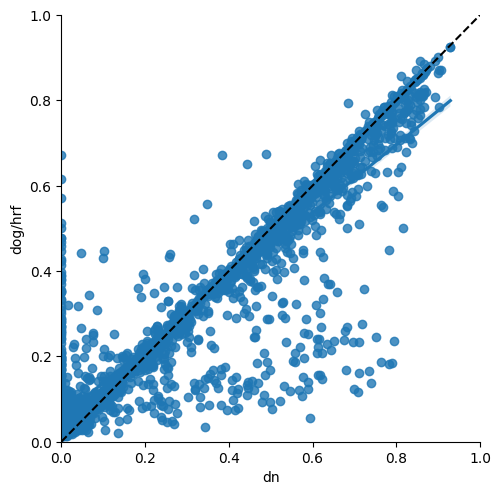

In [304]:
r2 = pd.concat((r2_gd, r2_dog_hrf, r2_dn), keys=['gauss', 'dog/hrf', 'dn'], axis=1)


sns.lmplot(x='dn', y='dog/hrf', data=r2)
plt.plot([0, 1], [0, 1], 'k--')

plt.xlim(0, 1)
plt.ylim(0, 1)

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_21537/891951915.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(pars_dn['neural_baseline'])
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_21537/891951915.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(pars_dn['surro

<Axes: xlabel='surround_baseline', ylabel='Density'>

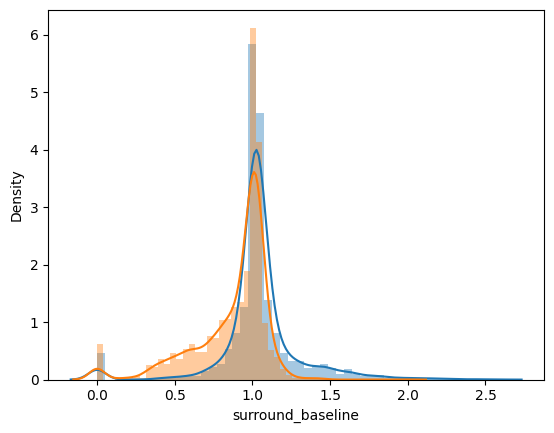

In [305]:
sns.distplot(pars_dn['neural_baseline'])
sns.distplot(pars_dn['surround_baseline'])

In [306]:
r2_dn = par_fitter_dn.get_rsq(pars_dn).sort_values(ascending=False)

best_voxels_dn = r2_dn.index[:200]

In [308]:
model.parameter_labels

['x',
 'y',
 'sd',
 'baseline',
 'amplitude',
 'srf_amplitude',
 'srf_factor',
 'neural_baseline',
 'surround_baseline',
 'hrf_delay',
 'hrf_dispersion']

In [309]:
from braincoder.optimize import ResidualFitter, StimulusFitter

resid_fitter_dn = ResidualFitter(model, d.loc[:, best_voxels_dn], parameters=pars_dn.loc[best_voxels_dn])
omega_dn, dof_dn = resid_fitter_dn.fit()



init_tau: 0.2272924929857254, 0.4175529479980469
USING A PSEUDO-WWT!
WWT max: 9288.158203125


  0%|          | 0/1000 [00:00<?, ?it/s]

In [312]:
# Do the same for the DoG-model
stim_fitter_dn = StimulusFitter(data['v1_timeseries'].loc[:, best_voxels_dn], model, omega_dn)
reconstructed_stimulus_dn = stim_fitter_dn.fit(l2_norm=0.01, learning_rate=.1, max_n_iterations=500)

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

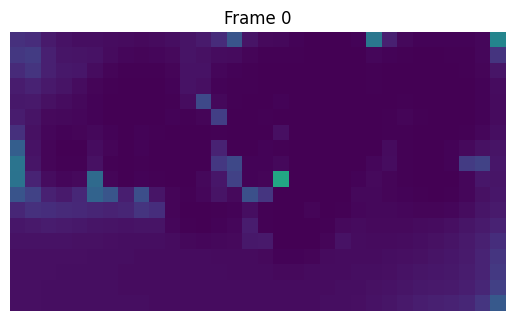

In [313]:
play_reconstruction(reconstructed_stimulus_dn)

In [283]:
# Do the same for the DoG-model
model_dog_hrf = DifferenceOfGaussiansPRF2DWithHRF(data=data['v1_timeseries'].loc[:, best_voxels_dog],
                                   paradigm=data['stimulus'],
                                   hrf_model=hrf_model,
                                   parameters=pars_dog_hrf.loc[best_voxels_dog],
                                   grid_coordinates=data['grid_coordinates'],
                                   flexible_hrf_parameters=False)
stim_fitter_dog = StimulusFitter(data['v1_timeseries'].loc[:, best_voxels_dog], model_dog_hrf, omega_dog)
reconstructed_stimulus_dog_hrf = stim_fitter_dog.fit(l2_norm=0.01, learning_rate=.1)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

(1, 200, 7) (1, 200, 5)


KeyboardInterrupt: 

In [161]:
pred_dn = model.predict(parameters=pars_dn)

In [187]:
pars_dog.loc['304']

parameter
x                 4.434072
y                -4.058451
sd                0.039745
baseline         -0.261228
amplitude         5.385951
srf_amplitude     0.243845
srf_factor        3.317802
hrf_delay         4.515006
hrf_dispersion    0.904686
Name: 304, dtype: float32

In [155]:
ix = (r2['r2_dn'] - r2['r2_dog_hrf']).idxmax()

<Axes: xlabel='frame'>

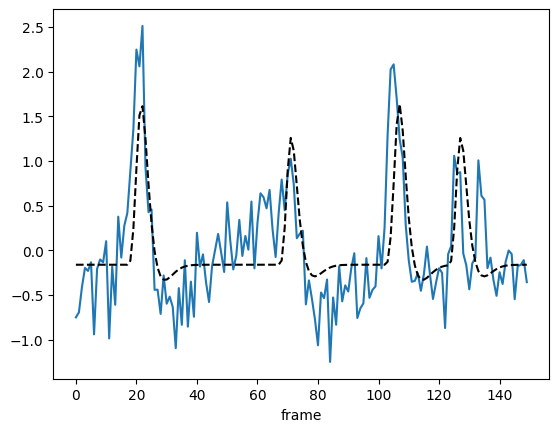

In [223]:
ix = '304'
d[ix].plot()
pred_gd[ix].plot(c='k', ls='--')
pred_dn[ix].plot(c='r', ls='--')

In [188]:
pars_dn.loc['304']

parameter
x                    0.0
y                    0.0
sd                   0.0
baseline             0.0
amplitude            0.0
srf_amplitude        0.0
srf_factor           0.0
neural_baseline      0.0
surround_baseline    0.0
hrf_delay            0.0
hrf_dispersion       0.0
Name: 304, dtype: float32

In [185]:
pars_dog.loc['304']

parameter
x                 4.434072
y                -4.058451
sd                0.039745
baseline         -0.261228
amplitude         5.385951
srf_amplitude     0.243845
srf_factor        3.317802
hrf_delay         4.515006
hrf_dispersion    0.904686
Name: 304, dtype: float32

In [232]:
pars_dn[(pars_dn != 0).all(1)].shape

(1688, 11)

In [233]:
pars_dog_hrf[(pars_dog_hrf != 0).all(1)].shape

(2308, 9)

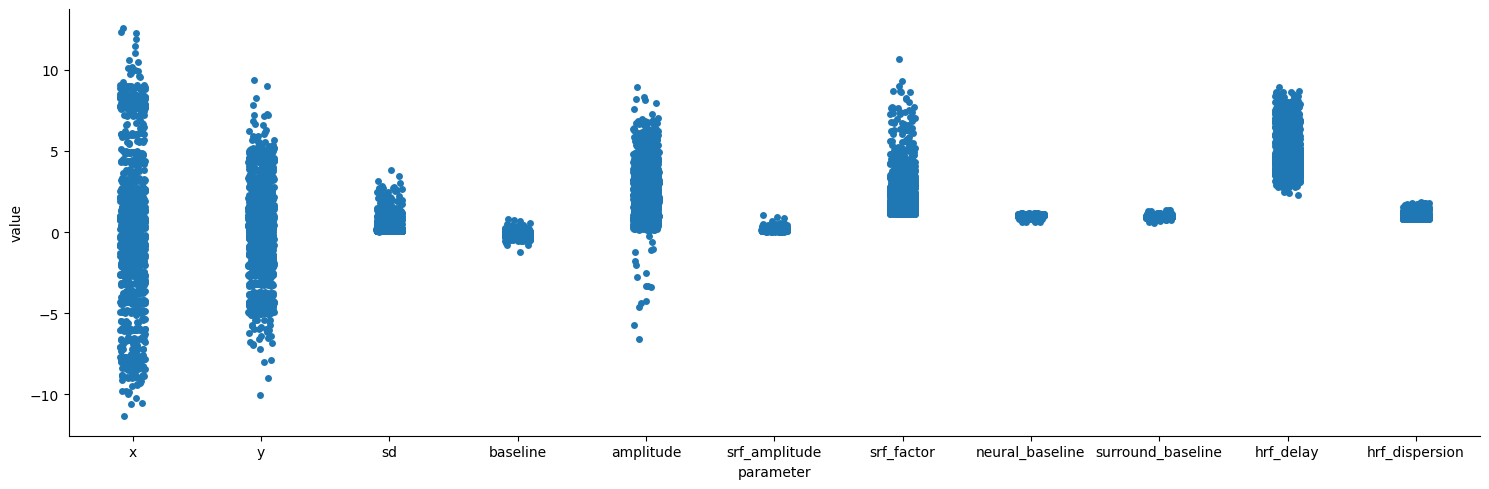

In [231]:
sns.catplot(x='parameter', y='value', data=pars_dn[(pars_dn != 0).all(1)].stack().to_frame('value'), aspect=3.)